In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import random
import mmh3
from bitarray import bitarray
import torch.optim as optim
import seaborn as sns
from latex import latexify, format_axes
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
latexify(columns=2)

In [23]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [24]:
print(x_test[0].shape)  

(28, 28)


In [25]:
class SimpleEncoder(nn.Module):
    def __init__(self):
        super(SimpleEncoder, self).__init__()
        # A simple CNN encoder: input (batch_size,channels,height,width) -> output vector (batch_size,128)
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # 14x14 -> 7x7
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc = nn.Linear(32 * 7 * 7, 128)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x  # output shape: (batch_size, 128)
    
class NeuralBloomFilter(nn.Module):
    def __init__(self, memory_slots=10, word_size=32, class_num=1):
        super().__init__()
        self.encoder = SimpleEncoder()
        self.fc_q    = nn.Linear(128, word_size)
        self.fc_w    = nn.Linear(128, word_size)
        self.A       = nn.Parameter(torch.randn(word_size, memory_slots))
        self.register_buffer('M', torch.zeros(memory_slots, word_size))
        inp_dim = memory_slots*word_size + word_size + 128
        self.mlp = nn.Sequential(
            nn.Linear(inp_dim, 128),
            nn.ReLU(),
            nn.Linear(128, class_num)
        )

    def controller(self, x):
        """
        x -> (B, 1, 28, 28): input image
        Runs the encoder, computes query q, write word w, and normalized address a.
        Returns (a, w, z).
        """
        z = self.encoder(x)                   # (B,128)
        q = self.fc_q(z)                      # (B,word_size)
        w = self.fc_w(z)                      # (B,word_size)
        a_logits = q @ self.A                 # (B,slots)
        a = F.softmax(a_logits, dim=1)        # (B,slots)
        return a, w, z

    def write(self, x):
        """
        Write all x in one shot:
          M ← M + ∑_i w_i a_i^T
        """
        a, w, _ = self.controller(x)          # a:(B,slots), w:(B,word_size)
        # Outer product per sample: update_i[k,p] = a[i,k] * w[i,p]
        # Stack them and sum over batch:
        # shape: (B, slots, word_size)
        update = torch.einsum('bk,bp->bkp', a, w)
        # Add to memory and detach so writes don't backprop through time:
        self.M = self.M + update.sum(dim=0).detach()

    def read(self, x):
        """
        Read operation:
          r_i = flatten( M ⊙ a_i )  (componentwise)
          logits = f_out([r_i, w_i, z_i])
        """
        a, w, z = self.controller(x)          # (B,slots), (B,word_size), (B,128)
        # M ⊙ a_i: scale each row of M by a_i:
        # shape before flatten: (B, slots, word_size)
        r = (a.unsqueeze(2) * self.M.unsqueeze(0)).reshape(x.size(0), -1)  # (B, slots*word_size)
        # Concatenate r, w, z:
        concat = torch.cat([r, w, z], dim=1)                              # (B, inp_dim)
        logits = self.mlp(concat)                                          # (B, class_num)
        return logits

In [26]:
class BloomFilter:
    """
    Standard Bloom Filter with customizable size and hash count.
    """
    def __init__(self, m: int, k: int):
        """
        Args:
            m: Number of bits in the filter bit array.
            k: Number of hash functions.
        """
        self.m = m
        self.k = k
        self.bits = bitarray(m)
        self.bits.setall(0)

    def add(self, key_bytes: bytes):
        """Insert a key (bytes) into the Bloom filter."""
        for i in range(self.k):
            idx = mmh3.hash(key_bytes, i) % self.m
            self.bits[idx] = 1

    def __contains__(self, key_bytes: bytes) -> bool:
        """Check membership of a key (bytes)."""
        return all(self.bits[mmh3.hash(key_bytes, i) % self.m]
                   for i in range(self.k))

class SimHashLSH:
    """
    Locality-Sensitive Hashing via random hyperplanes (SimHash).
    """
    def __init__(self, dim: int = 128, bits: int = 64):
        """
        Args:
            dim: Dimensionality of input embeddings.
            bits: Number of bits in the SimHash fingerprint.
        """
        # Random hyperplanes drawn from Gaussian distribution
        self.hyperplanes = np.random.randn(bits, dim).astype(np.float32)

    def compute(self, emb: np.ndarray) -> bytes:
        """Compute a `bits`-bit SimHash fingerprint for the embedding."""
        projections = np.dot(self.hyperplanes, emb)  # shape (bits,)
        bits_arr = (projections >= 0).astype(np.uint8)  # 1 if >=0, else 0
        packed = np.packbits(bits_arr)  # pack each 8 bits into a byte
        return packed.tobytes()         # result length = bits//8

class BackupBloomFilter:
    """
    Combines a learned classifier or embedding-based filter with a backup Bloom filter.
    """
    def __init__(self, encoder, bbf_size: int, bbf_hashes: int,
                 lsh_bits: int = 64):
        """
        Args:
            encoder: Function or model that maps an input image -> 1D embedding (np.ndarray, shape (dim,)).
            classifier: Function or model that maps embedding -> bool (returns True if "in set").
            bbf_size: Number of bits in the backup Bloom filter.
            bbf_hashes: Number of hash functions for the BBF.
            lsh_bits: Number of bits in SimHash fingerprint.
        """
        self.encoder = encoder
        self.lsh = SimHashLSH(dim=encoder.fc.out_features, bits=lsh_bits)
        self.bbf = BloomFilter(m=bbf_size, k=bbf_hashes)

    def insert(self, image):
        """Insert an image into the backup filter (and optionally train classifier)."""
        emb_t = self.encoder(image)          # expects np.ndarray shape (B, dim)
        emb = emb_t.squeeze(0).detach().cpu().numpy()
        key = self.lsh.compute(emb)
        self.bbf.add(key)
        # Optionally: classifier.fit or online update here

    def query(self, image) -> bool:
        """Query the learned filter, fallback to BBF for zero false negatives."""
        emb_t = self.encoder(image) # expects np.ndarray shape (B, dim)
        emb = emb_t.squeeze(0).detach().cpu().numpy()
        key = self.lsh.compute(emb)
        return (key in self.bbf)


In [27]:
def sample_task(labels, storage_set_size, num_queries, class_num):
    class_to_indices = {}
    for idx, label in enumerate(labels):
        if label not in class_to_indices:
            class_to_indices[label] = []
        class_to_indices[label].append(idx)
    
    storage_indices = random.sample(class_to_indices[class_num], storage_set_size)

    num_in = num_queries // 2
    num_out = num_queries - num_in
    query_in_indices = random.sample(class_to_indices[class_num], num_in)
    other_classes = [c for c in class_to_indices if c != class_num]
    query_out_indices = []
    for _ in range(num_out):
        other_class = random.choice(other_classes)
        query_out_indices.append(random.choice(class_to_indices[other_class]))
    
    query_indices = query_in_indices + query_out_indices
    # define target as [1,0] for in-class and [0,1] for out-of-class
    targets = []
    for i in range(num_in):
        targets.append(1)
    for i in range(num_out):
        targets.append(0)
    
    targets = torch.tensor(targets, dtype=torch.float32).unsqueeze(1) 
    return storage_indices, query_indices, targets

In [28]:
def meta_train(model, dataset, labels, optimizer, criterion, device, meta_epochs=10, storage_set_size=60, num_queries=10):
    
    model.train()
    total_loss = 0.0
    classes = [0,8,9,6]

    for epoch in range(meta_epochs):
        
        class_num = random.choice(classes)
        storage_indices, query_indices, targets= sample_task(labels, storage_set_size, num_queries, class_num)
        storage_images = dataset[storage_indices]
        storage_images = torch.tensor(storage_images, dtype=torch.float32).unsqueeze(1)
        
        query_images = dataset[query_indices]
        query_images = torch.tensor(query_images, dtype=torch.float32).unsqueeze(1)
        
        
        model.M.zero_()
        
        _ = model.write(storage_images)  # Expected shape: (storage_set_size, word_size)
        
        
        logits = model.read(query_images)  # Expected shape: (num_queries, class_num)
        
        
        probs = torch.sigmoid(logits) 
        
        # Convert probabilities to binary predictions
        predictions = (probs > 0.5).float()
        
    
        fnr = 0
        fpr = 0
        for i in range(len(predictions)):
            if predictions[i] == 0 and targets[i] == 1:
                fnr += 1
            elif predictions[i] == 1 and targets[i] == 0:
                fpr += 1
        
        loss = criterion(logits, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        total_loss += loss.item()
        if (epoch + 1) % 100 == 0:
            avg_loss = total_loss / (epoch + 1)
            print(f"Epoch [{epoch+1}/{meta_epochs}], Loss: {loss.item():.4f}, False Positive Rate: {fpr}, False Negative Rate: {fnr}")
    
    return total_loss / meta_epochs

In [6]:
def opt_m(n,p):
    m = - n * np.log(p) / (np.log(2)**2)
    return int(m)

def opt_k(n,m):
    k = (m / n) * np.log(2)
    return int(k)

In [ ]:


if __name__ == '__main__':
    # Hyperparameters
    meta_epochs = 1
    storage_set_size = 100
    num_queries = 100
    learning_rate = 1e-6
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = NeuralBloomFilter(memory_slots=512, word_size=64, class_num=1).to(device)
    
    
    criterion = nn.BCEWithLogitsLoss()
    
    # Use Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Start meta-training
    avg_loss = meta_train(model, x_test, y_test,optimizer, criterion, device,
                          meta_epochs=meta_epochs,
                          storage_set_size=storage_set_size,
                          num_queries=num_queries)
    print(f"Meta-training completed. Average Loss: {avg_loss:.4f}")   

Meta-training completed. Average Loss: 0.9080


In [30]:
class_to_indices = {}
for idx, label in enumerate(y_test):
    if label not in class_to_indices:
        class_to_indices[label] = []
    class_to_indices[label].append(idx)

imp_labels = class_to_indices[0] + class_to_indices[8] + class_to_indices[9] + class_to_indices[6]
other_labels = class_to_indices[1] + class_to_indices[2] + class_to_indices[3] + class_to_indices[4] + class_to_indices[5] + class_to_indices[7]


# prepare a images from imp_labels
imp_images = torch.zeros((len(imp_labels), 1, 28, 28))
for i in range(len(imp_labels)):
    imp_images[i] = torch.tensor(x_test[imp_labels[i]], dtype=torch.float32).unsqueeze(0)
print(imp_images.shape)

# other images
other_images = torch.zeros((len(other_labels), 1, 28, 28))
for i in range(len(other_labels)):
    other_images[i] = torch.tensor(x_test[other_labels[i]], dtype=torch.float32).unsqueeze(0)
print(other_images.shape)

# Prepare a query set with 50% in-class and 50% out-of-class samples
query_set = torch.zeros(500, 1, 28, 28)
query_labels = []
for i in range(250):
    query_set[i] = imp_images[i]
    query_labels.append(1)  # In-class
for i in range(250, 500):
    query_set[i] = other_images[i-250]
    query_labels.append(0)  # Out-of-class
print(query_set.shape)


backupBloomFilter = BackupBloomFilter(model.encoder, bbf_size=opt_m(10000, 0.01), bbf_hashes=opt_k(10000, opt_m(10000, 0.01)), lsh_bits=64)
for i in range(len(imp_labels)):
    backupBloomFilter.insert(imp_images[i].unsqueeze(0))

# Clean-up the model memory
model.M.zero_()

# now insert the test minist dataset into the model
for i in range(len(imp_images)):
    image = imp_images[i]
    image = torch.tensor(image.clone().detach(), dtype=torch.float32).unsqueeze(0)
    model.write(image)

fnr = 0
fpr = 0
# now test the query set
for i in range(len(query_set)):
    image = query_set[i]
    image = torch.tensor(image.clone().detach(), dtype=torch.float32).unsqueeze(0)
    logits = model.read(image)  
    probs = torch.sigmoid(logits) 
    
    if 0.4 < probs.item() < 0.8:
        # check if the image is in the backup bloom filter
        pred = backupBloomFilter.query(image)
        if pred:
            probs = torch.tensor(1.0, dtype=torch.float32)
        else:
            probs = torch.tensor(0.0, dtype=torch.float32)
    predictions = (probs > 0.5).float()
    
    if predictions == 0 and query_labels[i] == 1:
        fnr += 1
    elif predictions == 1 and query_labels[i] == 0:
        fpr += 1

print(f"False Negative Rate: {fnr}, False Positive Rate: {fpr}")

torch.Size([3921, 1, 28, 28])
torch.Size([6079, 1, 28, 28])
torch.Size([500, 1, 28, 28])


C:\Users\patel\AppData\Local\Temp\ipykernel_9888\2980962356.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image.clone().detach(), dtype=torch.float32).unsqueeze(0)
C:\Users\patel\AppData\Local\Temp\ipykernel_9888\2980962356.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image.clone().detach(), dtype=torch.float32).unsqueeze(0)


False Negative Rate: 238, False Positive Rate: 0


In [31]:
class_to_indices = {}
for idx, label in enumerate(y_test):
    if label not in class_to_indices:
        class_to_indices[label] = []
    class_to_indices[label].append(idx)

imp_labels = class_to_indices[0] + class_to_indices[8] + class_to_indices[9] + class_to_indices[6] 
other_labels = class_to_indices[1] + class_to_indices[2] + class_to_indices[3] + class_to_indices[4] + class_to_indices[5] + class_to_indices[7]


# prepare a images from imp_labels
imp_images = torch.zeros((len(imp_labels), 1, 28, 28))
for i in range(len(imp_labels)):
    imp_images[i] = torch.tensor(x_test[imp_labels[i]], dtype=torch.float32).unsqueeze(0)

# other images
other_images = torch.zeros((len(other_labels), 1, 28, 28))
for i in range(len(other_labels)):
    other_images[i] = torch.tensor(x_test[other_labels[i]], dtype=torch.float32).unsqueeze(0)

# Prepare a query set with 50% in-class and 50% out-of-class samples
query_set = torch.zeros(1000, 1, 28, 28)
query_labels = []
for i in range(500):
    query_set[i] = imp_images[i]
    query_labels.append(1)  # In-class
for i in range(500, 1000):
    query_set[i] = other_images[i-250]
    query_labels.append(0)  # Out-of-class
print(query_set.shape)




torch.Size([1000, 1, 28, 28])


In [32]:
model_sizes = [1024, 512, 256, 128, 64, 32, 16]
storage_set_sizes = [512, 256, 128, 64, 32, 16, 8]
epochs = [500, 600, 700, 800, 900, 900, 900]
avg_losses = []
fprs = []
fnrs = []
for i in range(len(model_sizes)):

    # Hyperparameters
    meta_epochs = 500
    storage_set_size = storage_set_sizes[i]
    num_queries = storage_set_sizes[i] // 2
    learning_rate = 1e-5
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = NeuralBloomFilter(memory_slots=model_sizes[i], word_size=64, class_num=1).to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    avg_loss = meta_train(model, x_test, y_test,optimizer, criterion, device,
                          meta_epochs=meta_epochs,
                          storage_set_size=storage_set_size,
                          num_queries=num_queries)
    avg_losses.append(avg_loss)
    print(f"Meta-training completed. Average Loss: {avg_loss:.4f}")   
    
    
    print(f"Testing Time")
    
    backupBloomFilter = BackupBloomFilter(model.encoder, bbf_size=opt_m(10000, 0.01), bbf_hashes=opt_k(10000, opt_m(10000, 0.01)), lsh_bits=64)
    for j in range(len(imp_labels)):
        backupBloomFilter.insert(imp_images[j].unsqueeze(0))
    
    model.M.zero_()

    # now insert the test minist dataset into the model
    for j in range(len(imp_images)):
        image = imp_images[j]
        image = image.clone().detach().float().unsqueeze(0)
        model.write(image)

    fnr = 0
    fpr = 0
    # now test the query set
    for j in range(len(query_set)):
        image = query_set[j]
        image = image.clone().detach().float().unsqueeze(0)
        logits = model.read(image)  
        probs = torch.sigmoid(logits) 
        
        if 0.4 < probs.item() < 0.8:
            # check if the image is in the backup bloom filter
            pred = backupBloomFilter.query(image)
            if pred:
                probs = torch.tensor(1.0, dtype=torch.float32)
            else:
                probs = torch.tensor(0.0, dtype=torch.float32)
        predictions = (probs > 0.5).float()
        
        if predictions == 0 and query_labels[j] == 1:
            fnr += 1
        elif predictions == 1 and query_labels[j] == 0:
            fpr += 1
    fprs.append(fpr)
    fnrs.append(fnr)
    print()
    print(f"False Negative Rate: {fnr}, False Positive Rate: {fpr}")
    print("=================================================================================================================")
    print()
    
    

Epoch [100/500], Loss: 0.6947, False Positive Rate: 28, False Negative Rate: 24
Epoch [200/500], Loss: 0.4828, False Positive Rate: 26, False Negative Rate: 25
Epoch [300/500], Loss: 0.5609, False Positive Rate: 37, False Negative Rate: 40
Epoch [400/500], Loss: 0.3402, False Positive Rate: 8, False Negative Rate: 12
Epoch [500/500], Loss: 0.2275, False Positive Rate: 9, False Negative Rate: 13
Meta-training completed. Average Loss: 0.4629
Testing Time

False Negative Rate: 1, False Positive Rate: 53

Epoch [100/500], Loss: 0.4164, False Positive Rate: 8, False Negative Rate: 14
Epoch [200/500], Loss: 0.4708, False Positive Rate: 8, False Negative Rate: 12
Epoch [300/500], Loss: 0.2785, False Positive Rate: 1, False Negative Rate: 12
Epoch [400/500], Loss: 0.2394, False Positive Rate: 8, False Negative Rate: 7
Epoch [500/500], Loss: 0.4218, False Positive Rate: 6, False Negative Rate: 17
Meta-training completed. Average Loss: 0.4193
Testing Time

False Negative Rate: 6, False Positive 

In [37]:
fprs

[40, 56, 72, 76, 177, 259, 359]

In [39]:
fnrs

[1, 6, 7, 10, 13, 123, 389]

In [36]:
fprs[0] = 40
fprs[1] = 56
fprs[2] = 72
fprs[5] = 259

In [38]:
fnrs[2] = 7
fnrs[3] = 10
fnrs[5] = 123

In [2]:
fprs = [40, 56, 72, 76, 177, 259, 359]
fnrs = [1, 6, 7, 10, 13, 123, 389]
model_sizes = [1024, 512, 256, 128, 64, 32, 16]
# devide by 10 to all the values
fprs = [i/10 for i in fprs]
fnrs = [i/10 for i in fnrs]



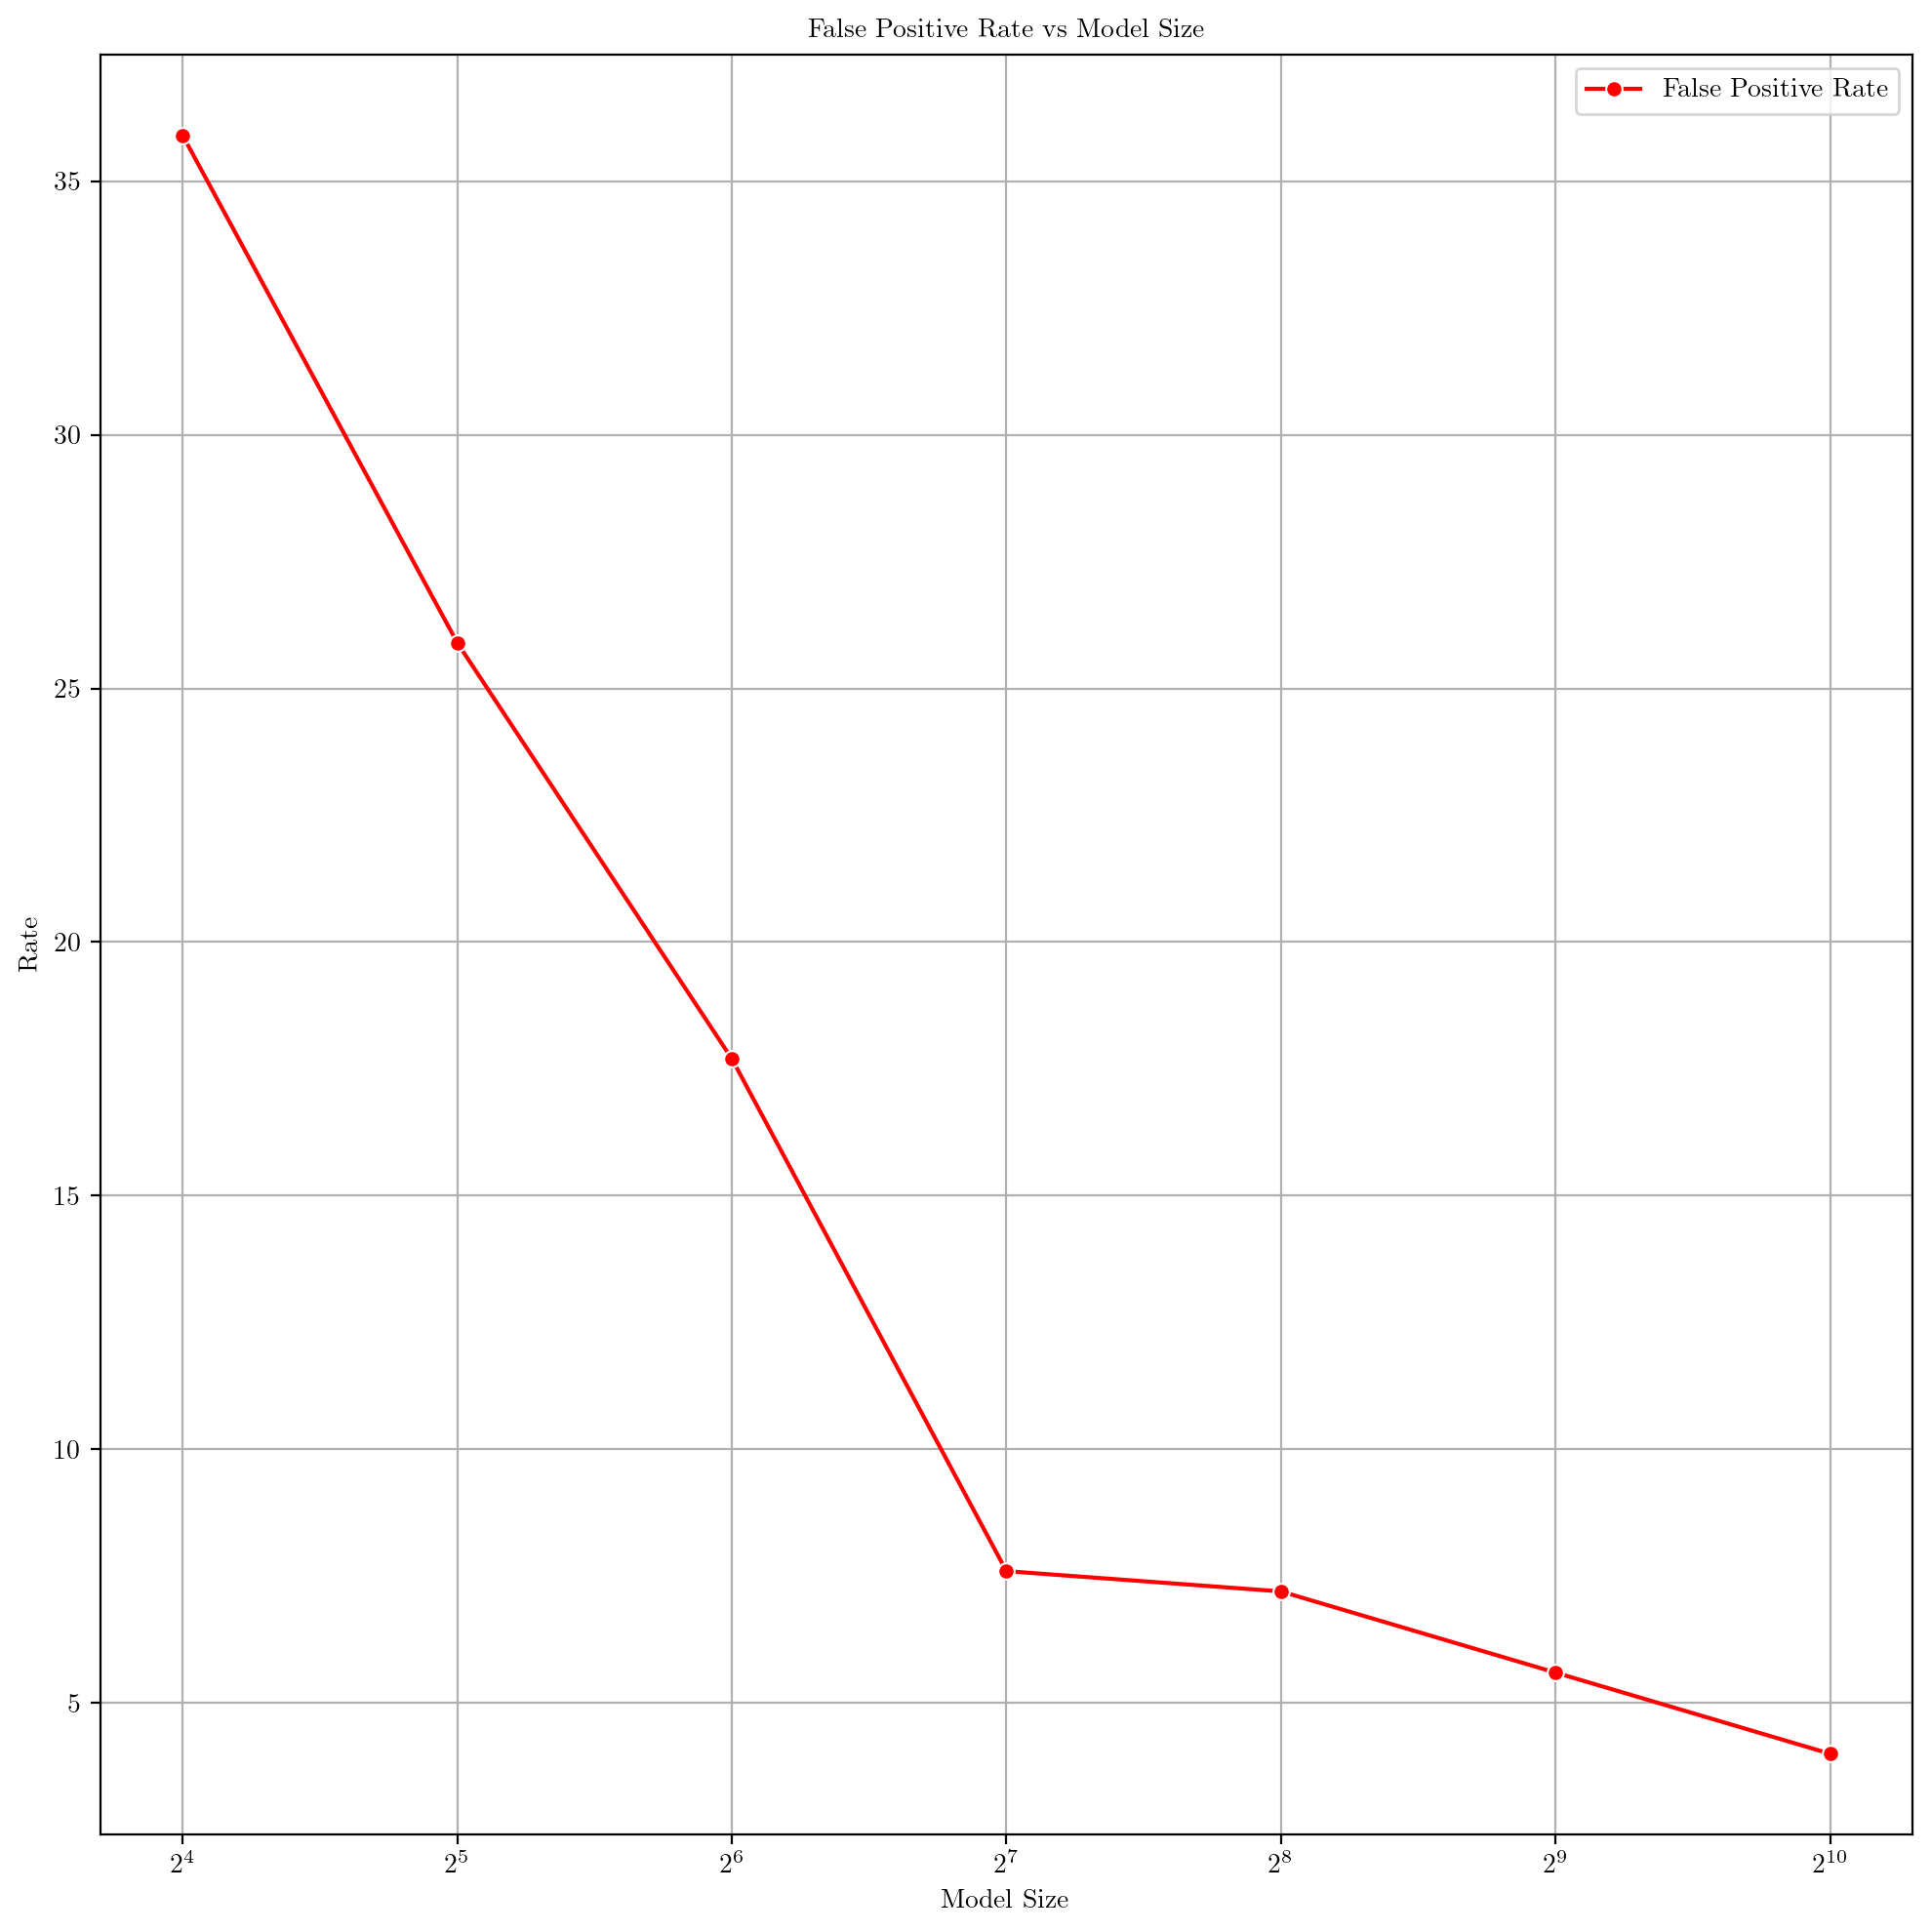

In [11]:



plt.figure(figsize=(10,10))
sns.lineplot(x=model_sizes, y=fprs, label='False Positive Rate', marker='o', color='red')
plt.xscale('log', base=2)
# sns.lineplot(x=model_sizes, y=fnrs, label='False Negative Rate', marker='o', color='blue')
plt.title('False Positive Rate vs Model Size')
plt.xlabel('Model Size')
plt.ylabel('Rate')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

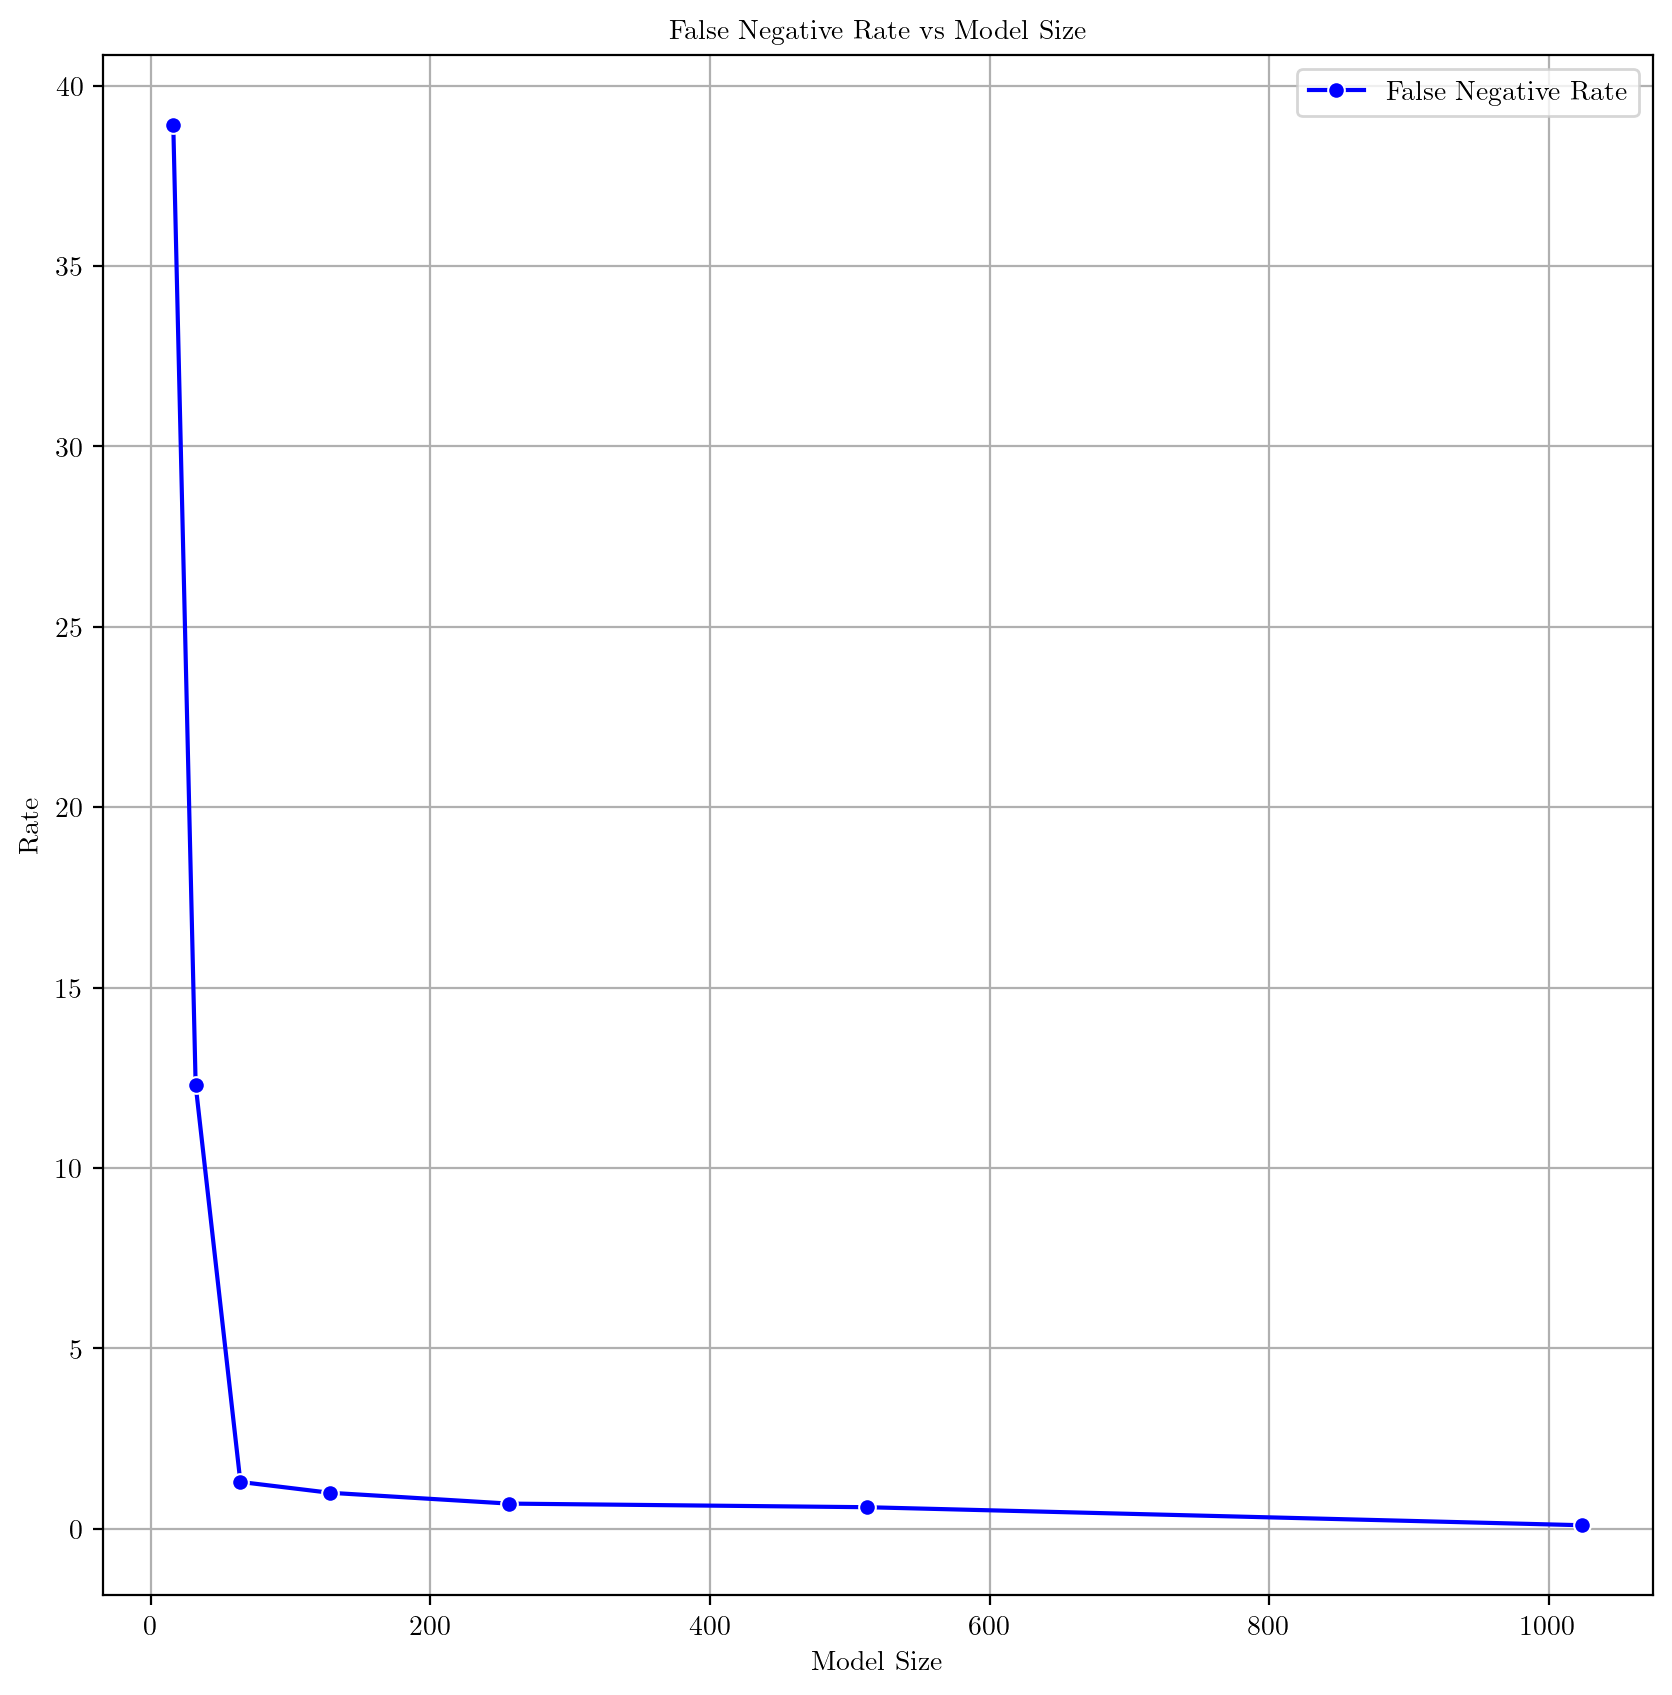

In [10]:
plt.figure(figsize=(10, 10))
sns.lineplot(x=model_sizes, y=fnrs, label='False Negative Rate', marker='o', color='Blue')
# sns.lineplot(x=model_sizes, y=fnrs, label='False Negative Rate', marker='o', color='blue')
plt.title('False Negative Rate vs Model Size')
plt.xlabel('Model Size')
plt.ylabel('Rate')
plt.legend()
plt.grid()
plt.show()

[14.0284423828125, 13.173583984375, 12.5350341796875, 12.397705078125, 10.249755859375, 9.2825927734375, 8.4530029296875]
[4.0, 2.0, 1.0, 0.5, 0.25, 0.125, 0.0625]


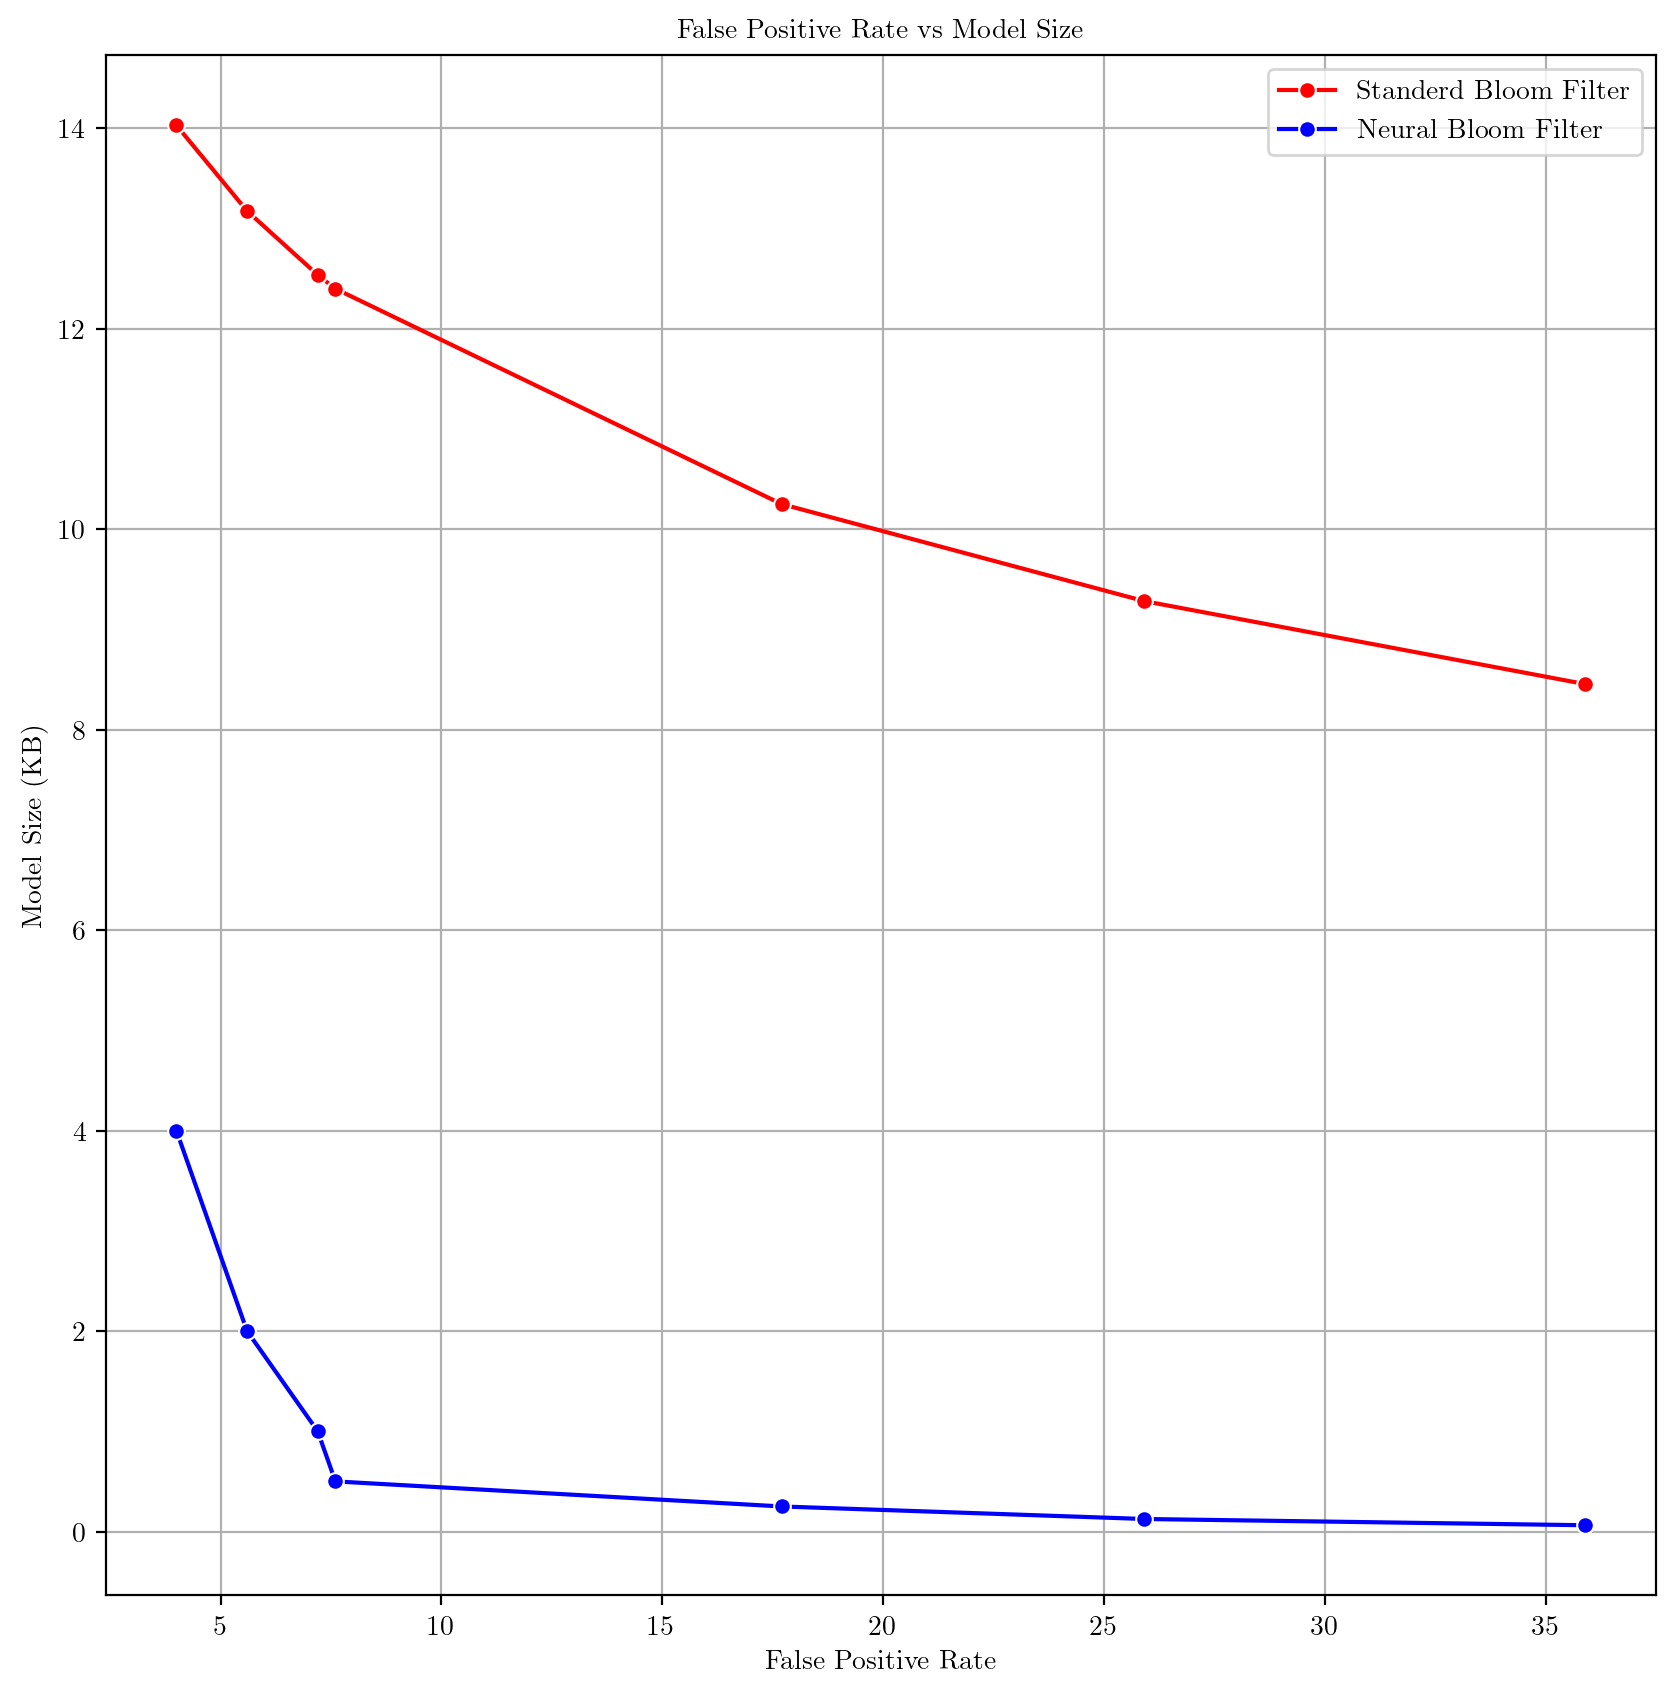

In [8]:

fprs.sort()
bloom_filter_sizes = []

for fpr in fprs:
    m = opt_m(10000, fpr/1000)
    # print(m)
    # convert this size to KB
    size_kb = m / 8/ 1024
    bloom_filter_sizes.append(size_kb)
print(bloom_filter_sizes)    
neural_BF_sizes = []
for model_size in model_sizes:
    size = model_size*32 # bits
    # print(size)
    size_kb = size / 8 / 1024 # convert to KB
    neural_BF_sizes.append(size_kb)
print(neural_BF_sizes)    
plt.figure(figsize=(10, 10))
# Plot a line plot between model sizes and fprs
sns.lineplot(x=fprs, y=bloom_filter_sizes, label='Standerd Bloom Filter', marker='o', color='red')
sns.lineplot(x=fprs, y=neural_BF_sizes, label='Neural Bloom Filter', marker='o', color='blue')
plt.title('False Positive Rate vs Model Size')
plt.xlabel('False Positive Rate')
plt.ylabel('Model Size (KB)')
plt.legend()
plt.grid()
plt.show()